In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import requests
import matplotlib.pyplot as plt
import os.path
from PIL import Image, ImageDraw
import cv2
import numpy as np
import statistics

def save_image(img):
    if os.path.exists(img):
        return
    data = requests.get('https://www.harmmade.com/vectorracer/tracks/{}'.format(img)).content
    with open(img, 'wb') as handler:
        handler.write(data)

save_image('oval.png')
image_orig=Image.open('oval.png')
image=image_orig.copy()
grid_step = 15

def boundaries_filter(x):
    if x != 0:
        return 1
    return 0

def find_start(img):
    xs = []
    ys = []
    for x in range(img.width):
        for y in range(img.height):
            v = image.getpixel((x,y))
            if v == 11:
                xs.append(x)
                ys.append(y)
    print(xs, ys)
    return statistics.median(xs), statistics.median(ys)

if 'start_point' not in globals():
    start_point = find_start(image_orig)

def find_track(image):
    im2=np.array(image)
    im2[im2!=0]=1
    pal=image.getpalette()
    cv2.floodFill(im2, None, start_point, 10, 0, 1)
    im2[im2!=10]=1
    im2[im2==10]=0
    im2=Image.fromarray(im2, mode='P')
    im2.putpalette(pal)
    return im2

track = find_track(image_orig)

In [25]:
def pt(pos):
    start_x = start_point[0]
    start_y = start_point[1]
    (x, y) = pos
    return (start_x + grid_step * x, start_y - grid_step * y)

def is_valid(pos):
    p = pt(pos)
    return p[0] >= 0 and p[1] >= 0 \
        and p[0] < track.width and p[1] < track.height \
        and track.getpixel(p) == 0

def is_finish(pos):
    p = pt(pos)
    return p[0] >= 0 and p[1] >= 0 \
        and p[0] < image.width and p[1] < image.height \
        and image_orig.getpixel(p) == 7
    

def is_valid_line(pos1, pos2):
    if pos1[0] >= 0 and pos2[0] < 0 and pos1[1] < 10:
        return False
    if not is_valid(pos1):
        return False
    for p in np.linspace(pos1, pos2, 10):
        if is_finish(p):
            return True
        if not is_valid(p):
            return False
    return is_valid(pos2)

def has_finished(pos1, pos2):
    if pos1[0] >= 0 and pos2[0] < 0 and pos1[1] < 10:
        return False
    if not is_valid(pos1):
        return False
    for p in np.linspace(pos1, pos2, 10):
        if is_finish(p):
            return True
        if not is_valid(p):
            return False
    return False

def finish(pos1, pos2):
    for p in np.linspace(pos1, pos2, 100):
        if is_finish(p):
            return p
    return None

def param(pos1, pos2, p):
    (x0, y0) = pos1
    (x1, y1) = pos2
    (x, y) = p
    num = (x1-x0)*(x-x0) + (y1-y0)*(y-y0)
    denom = (x1-x0)*(x1-x0) + (y1-y0)*(y1-y0)
    return num/denom

def get_dst(pos1, pos2):
    (x0, y0) = pos1
    (x1, y1) = pos2
    return (x1-x0)*(x1-x0)+(y1-y0)*(y1-y0)

def draw(pos, fill=None, outline=None, d=None):
    fill = fill or 100
    outline = outline or 30
    if is_valid(pos):
        d = 3
        fill = 6
    else:
        d = 10
        fill = 3
    img = ImageDraw.Draw(image)
    (px, py) = pt(pos)
    img.ellipse([(px-d, py-d), (px+d, py+d)], fill=fill, outline=outline)

def draw_line(pos0, pos1, fill=None):
    fill = fill or 77
    if is_valid_line(pos0, pos1):
        fill = 77
        width = 0
    else:
        fill = 3
        width = 3
    p0 = pt(pos0)
    p1 = pt(pos1)
    img = ImageDraw.Draw(image)
    img.line([p0, p1], fill=fill, width=width)

In [44]:
class State:
    def __init__(self, x=0, y=0, dx=0, dy=0):
        self.data = (x, y, dx, dy)
    
    def __hash__(self):
        return hash(self.data)
    
    def __str__(self):
        (x, y, dx, dy) = self.data
        return "({}, {}, {}, {})".format(x, y, dx, dy)
    
    def __repr__(self):
        (x, y, dx, dy) = self.data
        return "({}, {}, {}, {})".format(x, y, dx, dy)

    def step(self, cmd):
        (ddx, ddy) = cmd
        (x, y, dx, dy) = self.data
        return State(x + dx + ddx, y + dy + ddy, dx + ddx, dy + ddy)
    
    def step_back(self, cmd):
        (ddx, ddy) = cmd
        (x, y, dx, dy) = self.data
        return State(x - dx, y - dy, dx - ddx, dy - ddy)
    
    def pos(self):
        return (self.data[0], self.data[1])
    
    def data(self):
        return self.data
      
def bfs():
    state = State()
    l = [state]
    idx = 0
    d = {}
    back = {}
    d[state.data] = 0
    result = []
    found_distance = None
    while idx < len(l):
        el = l[idx]
        dist = d[el.data]
        idx = idx + 1
        if not found_distance is None and dist >= found_distance:
            break
        for ddx in (-1, 0, 1):
            for ddy in (-1, 0, 1):
                s = el.step((ddx, ddy))
                if abs(s.data[2]) > 6 or abs(s.data[3]) > 6:
                    continue
                if s.data in d:
                    continue
                if not is_valid_line(el.pos(), s.pos()):
                    continue
                back[s.data] = (ddx, ddy)
                d[s.data] = dist + 1
                if dist == 20:
                    draw_line(el.pos(),s.pos())
                if has_finished(el.pos(), s.pos()):
                    result.append(s.data)
                    found_distance = dist + 1
                else:
                    l.append(s)
    return d, l, found_distance, result, back
       
d, l, dst, result, back = bfs()

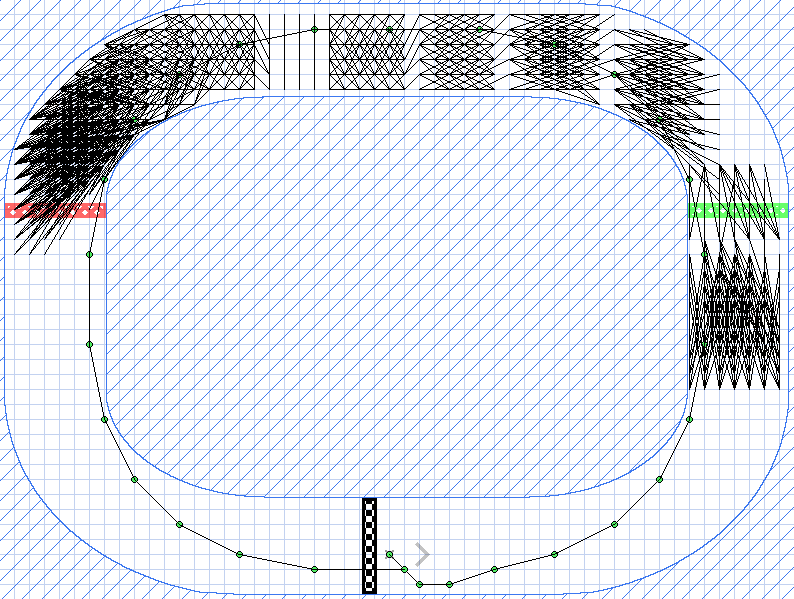

In [45]:
image

Pixel value (image.getpixel):
* equal to `0` - boundary
* equal to `1` - blank
* equal to `2` - grid
* equal to `3` - checkpoint (red)
* equal to `4` - checkpoint (red) intersecting grid
* equal to `5` - checkpoint (green)
* equal to `6` - checkpoint (green) intersecting grid
* equal to `7` - checkpoint (black, start/finish)
* equal to `8` - direction sign
* equal to `9` - direction sign intersecting grid
* equal to `10`- hatch boundaries
* equal to `11` - hatch center

In [35]:
results=[]
for r in result:
    chain = [r]
    while chain[-1] in back:
        (x,y,dx,dy) = chain[-1]
        st = back[chain[-1]]
        new_val = State(x,y,dx,dy).step_back(st).data
        chain.append(new_val)
    ch2 = [(x,y) for (x,y,_,_) in reversed(chain)]
    results.append(ch2)
    

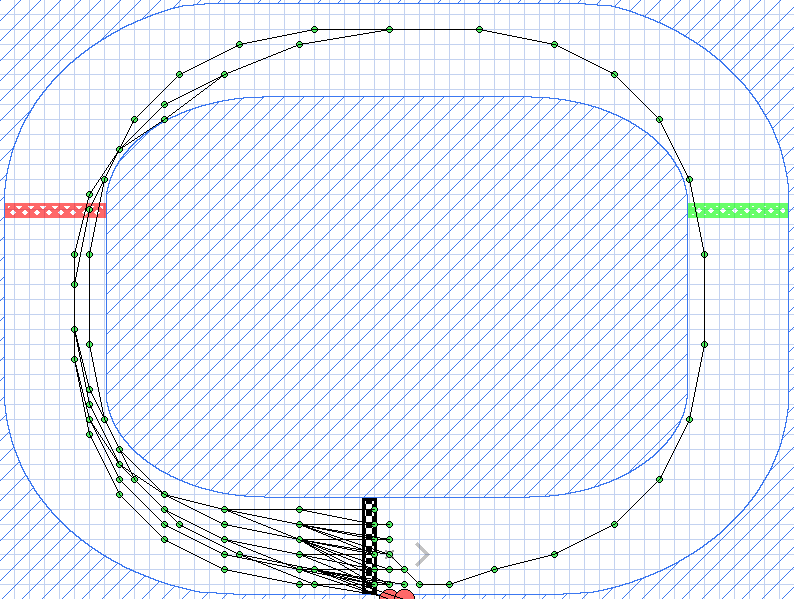

In [37]:
draw((0,0))
for r in results:
    for i in range(1, len(r)):
        draw(r[i])
        draw_line(r[i-1], r[i])
        
image

In [ ]:
[a,b] = results[0][-2:]
param(a, b, finish(a, b))

In [41]:
x = 1.343453564
round(x, 4)

1.3435

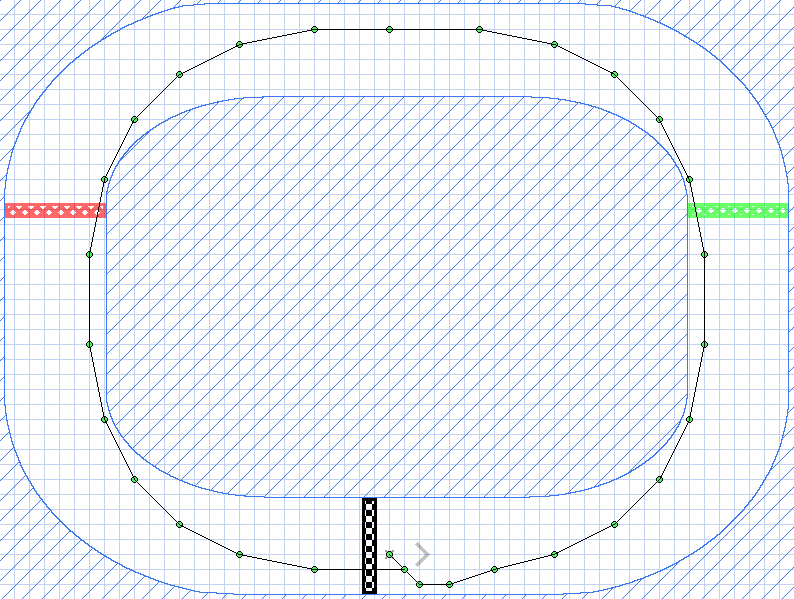

In [46]:
min_r = 100
min_dst = 100
res = []
for r in results:
    [a,b] = r[-2:]
    p = round(param(a, b, finish(a, b)),2)
    curr_dst = get_dst(a, b)
    if (p, curr_dst) < (min_r, min_dst):
        min_r = p
        min_dst = curr_dst
        res = [r]
    elif (p, curr_dst) == (min_r, min_dst):
        res.append(r)

results = res
image=image_orig.copy()
draw((0,0))
for r in results:
    for i in range(1, len(r)):
        draw(r[i])
        draw_line(r[i-1], r[i])
        
image 

In [43]:
image.save('oval-result.png')